In [117]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import seaborn as sn
import pandas as pd
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import torchvision.transforms as T
from torchvision import datasets, models, transforms
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import time
import copy
from tabulate import tabulate

In [120]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [121]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1650 Ti'

In [122]:
test_dir = 'C:/Users/gozde/OneDrive/Masaüstü/SELMA/test'
train_dir = 'C:/Users/gozde/OneDrive/Masaüstü/SELMA/train'

In [123]:
transforms_train = transforms.Compose([
    transforms.Resize((540, 960)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])
transforms_test = transforms.Compose([
    transforms.Resize((540, 960)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [124]:
train_dataset = datasets.ImageFolder(train_dir, transforms_train)
test_dataset = datasets.ImageFolder(test_dir, transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=0)

In [125]:
print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))
class_names = train_dataset.classes
print('Class names:', class_names)

Train dataset size: 234
Test dataset size: 70
Class names: ['day', 'fog', 'night', 'rain']


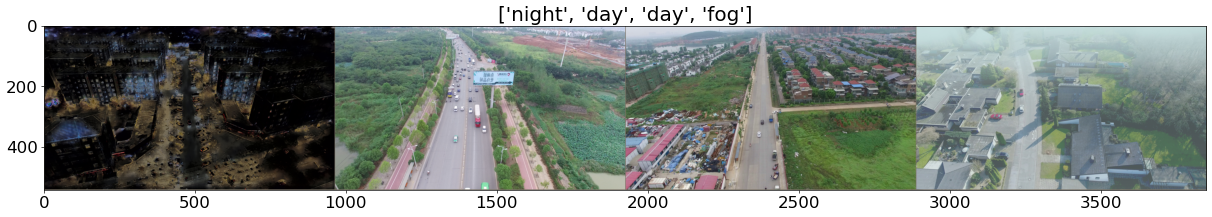

In [111]:
plt.rcParams['figure.figsize'] = [25, 20]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})
def imshow(input, title):
    # torch.Tensor --> numpy
    input = input.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    plt.imshow(input)
    plt.title(title)
    plt.show()

iterator = iter(train_dataloader)
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow(out, title=[class_names[x] for x in classes[:4]])


In [126]:
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
print('Number of features from pre-trained model', num_features)

Number of features from pre-trained model 512


In [127]:
# Adding a fully-connected layer for classification
model.fc = nn.Linear(num_features, 4)
model = model.to(device)

# loss Function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [128]:
def class_accuracy(model, dataloader, num_classes):
    class_correct = list(0. for _ in range(num_classes))
    class_total = list(0. for _ in range(num_classes))

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    class_accuracy = [class_correct[i] / class_total[i] * 100. if class_total[i] != 0 else 0 for i in range(num_classes)]
    return class_accuracy

In [129]:
train_loss = []
train_accuary = []
test_loss = []
test_accuary = []
y_pred = []
y_true = []

num_epochs = 10
start_time = time.time()

for epoch in range(num_epochs):
    print("Epoch {} running".format(epoch))
    # Training
    model.train()
    running_loss = 0.
    running_corrects = 0

    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data).item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset) * 100.
    train_loss.append(epoch_loss)
    train_accuary.append(epoch_acc)
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch+1, epoch_loss, epoch_acc, time.time() -start_time))

    # Testing
    model.eval()
    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data).item()

            # Save predictions and true labels
            outputs = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
            y_pred.extend(outputs) # Save Prediction
            labels = labels.data.cpu().numpy()
            y_true.extend(labels) # Save Truth

        epoch_loss = running_loss / len(test_dataset)
        epoch_acc = running_corrects / len(test_dataset) * 100.
        test_loss.append(epoch_loss)
        test_accuary.append(epoch_acc)
        print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch+1, epoch_loss, epoch_acc, time.time()- start_time))

Epoch 0 running


OutOfMemoryError: CUDA out of memory. Tried to allocate 32.00 MiB. GPU 0 has a total capacity of 4.00 GiB of which 0 bytes is free. Of the allocated memory 6.90 GiB is allocated by PyTorch, and 88.57 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
###
# printing accuracy and loss values for training and test
# Training: Selma (800), Test: Selma (400) for 10 epoch
df = pd.DataFrame({'Training Accuracy': train_accuary, 'Test Accuracy': test_accuary, 'Training Loss': train_loss, 'Test Loss':test_loss})
print("Training: Selma (800), Test: Selma (400)")
print(df)

####
# class accuracies
num_classes = len(train_dataset.classes)
class_names = ['day', 'fog', 'night', 'rain']

class_acc_train = class_accuracy(model, train_dataloader, num_classes)
class_acc_test = class_accuracy(model, test_dataloader, num_classes)

train_acc_df = pd.DataFrame({'Class': class_names, 'Training Accuracy': class_acc_train, 'Testing Accuracy': class_acc_test})

for i, acc in enumerate(class_acc_train):
    print(f'Training Accuracy for {class_names[i]}: {acc:.2f}%')

for i, acc in enumerate(class_acc_test):
    print(f'Testing Accuracy for {class_names[i]}: {acc:.2f}%')

#####
# Printing accuracy and loss plots

plt.figure(figsize=(12, 6))

# accuracy
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, num_epochs+1), train_accuary, '-o')
plt.plot(np.arange(1, num_epochs+1), test_accuary, '-o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])
plt.title('Train vs Test Accuracy over time')
plt.grid(True)

# loss
plt.subplot(1, 2, 2)
plt.plot(np.arange(1, num_epochs+1), train_loss, '-o')
plt.plot(np.arange(1, num_epochs+1), test_loss, '-o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.title('Train vs Test Loss over time')
plt.grid(True)

plt.tight_layout()
plt.show()

#####
# Confusion Matrix

classes = test_dataset.classes
print("Accuracy on Training set: ",accuracy_score(y_true, y_pred))
print('Confusion matrix: \n', confusion_matrix(y_true, y_pred))
print('Classification report: \n', classification_report(y_true, y_pred))

cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (7,7))
plt.title("Confusion matrix for Skin Cancer classification ")
sn.heatmap(df_cm, annot=True)